### Derive and transfer optimal masks

Derive optimal masks for CESM for 99.9% / 99% / 95% missing.

**Note:** Have different grid structures. For CESM, we have 96 x 144 lat-lon grid, with 8,276 total grid points. 0.1% hence means 8 grid points. 

--> Look for the top 8 grid points from CESM mean rel. loss reduction maps and transfer obtained mask to real world grid.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

# Next block for visualization, only if packages are pre-installed!
# import xarray as xr
# import hvplot.xarray
# import geoviews as gv
# import cartopy
# import cartopy.crs as ccrs
# import cmocean

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data, get_land_silhouette
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

### Load data

#### CESM and FOCI

In [3]:
## Prepare CESM and FOCI samples:

# Set path CESM and FOCI test data:
path_to_ESM_test_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/'

# Load CESM and FOCI test data:
data_CESM = load_data_set(data_path=path_to_ESM_test_data, data_source_name='CESM')
data_FOCI = load_data_set(data_path=path_to_ESM_test_data, data_source_name='FOCI')

# Get anomalies for CESM and FOCI test data:
CESM_anomaly = get_anomalies(feature='sea-surface-salinity', data_set=data_CESM)
FOCI_anomaly = get_anomalies(feature='sea-surface-salinity', data_set=data_FOCI)


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


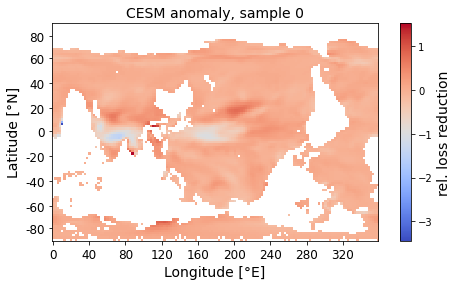

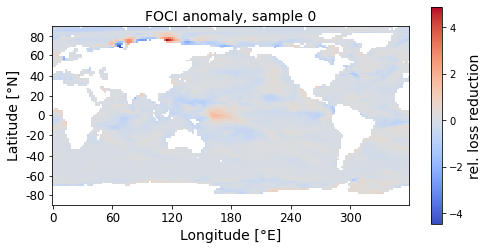

In [4]:
## Plot samples:

# CESM:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(CESM_anomaly[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('CESM anomaly, sample 0', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# slp FOCI:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(FOCI_anomaly[0], cmap="coolwarm", interpolation='nearest')#, vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('FOCI anomaly, sample 0', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

#### Infer grid dimensions

In [5]:
# Store grid dimensions:
n_lat_CESM = CESM_anomaly.shape[1]
n_lon_CESM = CESM_anomaly.shape[2]

# Check dimensions:
print('CESM')
print('====')
print('lat / lon:',n_lat_CESM,'/',n_lon_CESM)

CESM
====
lat / lon: 96 / 144


#### Infer absolute lat / lon values

In [6]:
# Store grid dimensions:
lat_CESM = data_CESM.lat.values
lon_CESM = data_CESM.lon.values

### Reload mean rel. loss reduction map for CESM

In [7]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-salinity' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sss' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_0_100'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_1'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sss_CESM_variable_range_0_100_factor_3_final/relevance_1

number of samples:  240
patch size:  1
max. number of patches to include:  50
max. acc. rel. loss as threshold:  0.9


In [8]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# Check dimensions:
print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (240, 96, 144)
patch_orders: (240, 13824)
rel_loss_reductions: (240, 13824)
abs_loss_reductions: (240, 13824)
acc_rel_loss_reductions: (240, 13824)


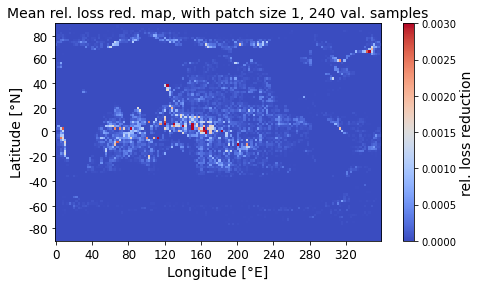

In [9]:
# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:n_samples],axis=0)

# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Clustering with GMM to find optimal masks

### Optimal masks for CESM grid

- Derive masks for CESM grid: Look for 8 / 83 / 414 clusters (=0.1% / 1% / 5% of valid grid points for CESM). But as representative for each cluster, don't take the **mean**, but the grid points with **maximum rel. loss reduction**.

#### 99.9% missing

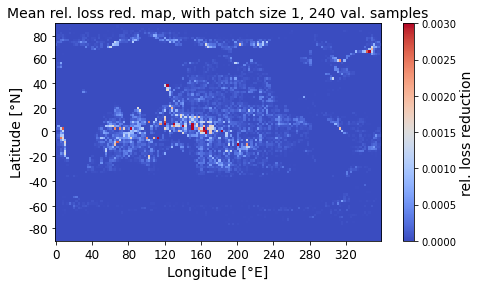

non-zero entries in mean rel. loss reduction map:  3607


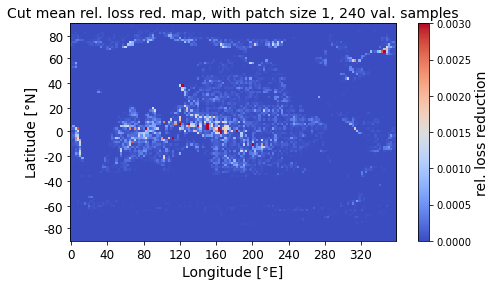

number of xy-tuples exceeding noise threshold 0.0 in mean rel. loss reduction map: 3607
number of desired clusters: 8 



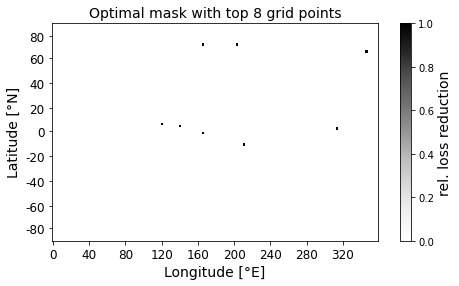

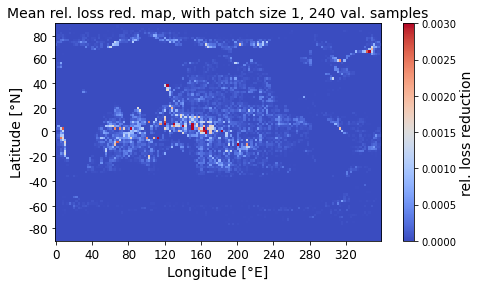

In [10]:
# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0.00
n_clusters = 8

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot FLIPPED resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_CESM):
    
    # Loop over latitude:
    for y in range(n_lat_CESM):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 8 (=0.1% of valid grid points for CESM sss grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_999 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_999_clusters = GMM_999.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over number of clusters:
for i in range(n_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_999_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_999_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_GMM_max = (np.zeros((n_lat_CESM,n_lon_CESM))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_999_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot FLIPPED optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_GMM_max,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [11]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_999.npy", mask_999_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sss_CESM_variable_range_0_100_factor_3_final/relevance_1


#### 99% missing

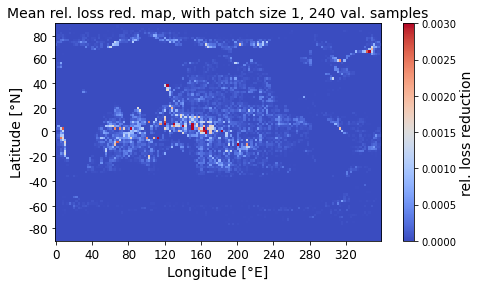

non-zero entries in mean rel. loss reduction map:  3607


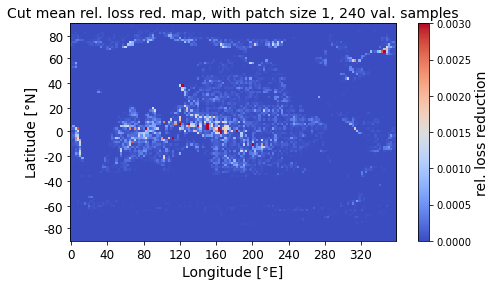

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 3607
number of desired clusters: 83 



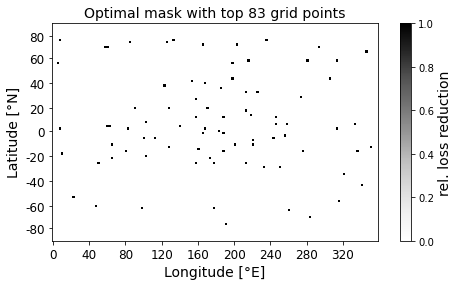

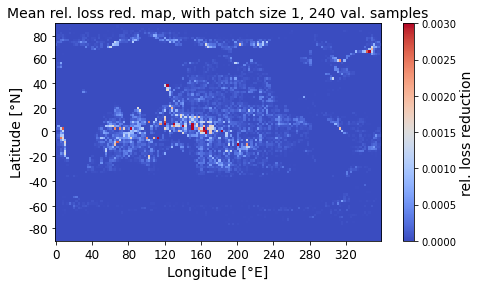

In [12]:
# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 83

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot FLIPPED resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_CESM):
    
    # Loop over latitude:
    for y in range(n_lat_CESM):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 83 (=1% of valid grid points for CESM sss grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_99 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_99_clusters = GMM_99.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over number of clusters:
for i in range(n_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_99_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_99_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_GMM_max = (np.zeros((n_lat_CESM,n_lon_CESM))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_99_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot FLIPPED optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_GMM_max,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [13]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_99.npy", mask_99_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sss_CESM_variable_range_0_100_factor_3_final/relevance_1


#### 95% missing

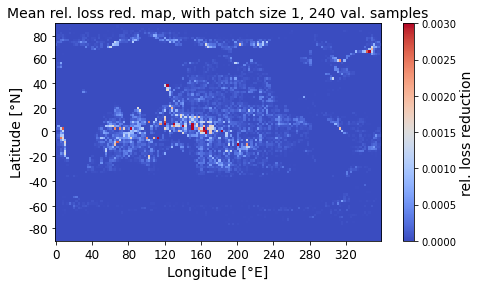

non-zero entries in mean rel. loss reduction map:  3607


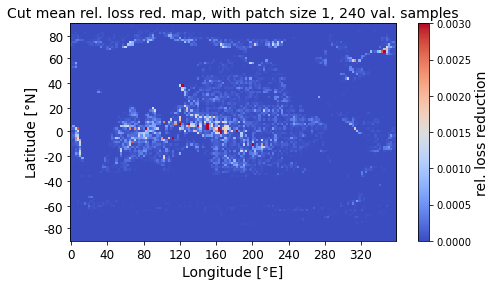

number of xy-tuples exceeding noise threshold 0 in mean rel. loss reduction map: 3607
number of desired clusters: 414 



/app/conda/lib/python3.8/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


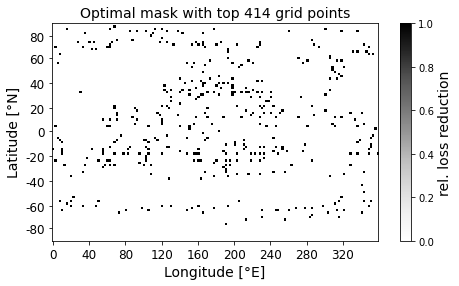

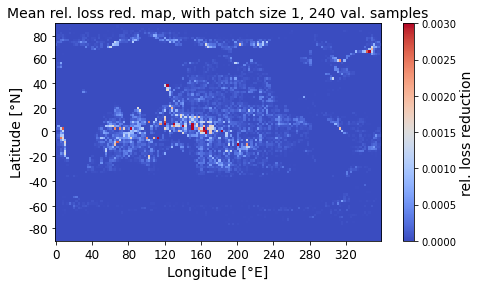

In [14]:
# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

## Start with clustering of x/y positions having non-zero rel. loss reduction:
## Optionally cut of noise in mean rel. loss reduction map:

# Set threshold:
noise_threshold = 0
n_clusters = 414

# Copy original mean rel. loss reduction map:
mean_rel_loss_reduction_map_cut = np.copy(mean_rel_loss_reduction_map)

# Set grid points below noise threshold to zero:
mean_rel_loss_reduction_map_cut[mean_rel_loss_reduction_map <= noise_threshold] = 0

# Plot FLIPPED resulting mean rel. loss reduction map with noise cut off as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map_cut,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Cut mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Create tuples of x/y positions on grid (= lon/lat), plus corresponding rel. loss reduction as z feature:
xyz_grid = []

# Loop over longitude:
for x in range(n_lon_CESM):
    
    # Loop over latitude:
    for y in range(n_lat_CESM):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > noise_threshold:
           
            # Store xy-tuple:
            xyz_grid.append([x,y,mean_rel_loss_reduction_map[y,x]])

# Convert list of xy-tuples to np.array:
xyz_grid = np.array(xyz_grid)

# Output number of obtained tuples:
print("number of xy-tuples exceeding noise threshold",noise_threshold,"in mean rel. loss reduction map:", len(xyz_grid))

# Output number of clusters to look for:
print("number of desired clusters:",n_clusters,"\n")

# Get clusters from GMM algorithms with pre-specified number of clusters = 414 (=5% of valid grid points for CESM sss grid).
# Note: Only use positional features (lat and lon), omit mean rel. loss reduction as feature:
GMM_95 = GaussianMixture(n_components=n_clusters, random_state=0).fit(xyz_grid[:,:2])

# Get clusters:
GMM_95_clusters = GMM_95.predict(xyz_grid[:,:2])

## Now look for grid point with highest rel. loss reduction as representative for each cluster:

# Initialize storage for grid positions:
xy_grid_max = []

# Loop over existing clusters. Note: Can have empty clusters.
for i in np.unique(GMM_95_clusters):
    
    # Get position in current cluster with highest rel. loss reduction:
    position_max = np.argmax(xyz_grid[GMM_95_clusters==i][:,2])
    
    # Store corresponding lat and lon positions:
    xy_grid_max.append(xyz_grid[GMM_95_clusters==i][position_max,:2])
    
# Convert list of xy-tuples to np.array:
xy_grid_max = np.array(xy_grid_max)

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_GMM_max = (np.zeros((n_lat_CESM,n_lon_CESM))!=0)

# Loop over positions of cluster representatives with max. rel. loss reduction:
for xy in xy_grid_max:
    # Set grid points to True. Note: Need to round obtained cluster means and convert to integer values.
    mask_95_GMM_max[np.round(xy[1],0).astype(int),np.round(xy[0],0).astype(int)]=True
    
# Plot FLIPPED optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95_GMM_max,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top '+str(n_clusters)+' grid points', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot FLIPPED resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mean_rel_loss_reduction_map,axis=0), cmap="coolwarm", interpolation='nearest', vmax=0.003)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(n_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [15]:
# Set path to store optimal missing masks:
path_to_store_masks = Path(
    'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'+
    mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95.npy", mask_95_GMM_max)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sss_CESM_variable_range_0_100_factor_3_final/relevance_1


### Cartopy plot

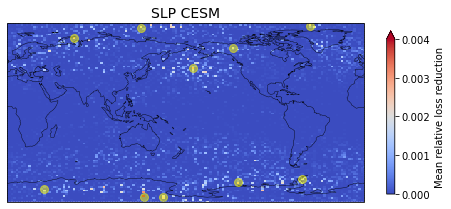

In [52]:
# Convert mean rel. loss red. map to xarray DataArray:
mean_rel_loss_reduction_map_xr = xr.DataArray(
    mean_rel_loss_reduction_map,
    dims=('lat', 'lon'),
    coords={'lat': data_CESM.lat, 'lon': data_CESM.lon}
)

# Plot:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))#Robinson(central_longitude=180))

# Make the map global and add coastlines
ax.set_global()
ax.coastlines(linewidth=0.4)

# Add mean loss reduction map as heatmap:
mean_rel_loss_reduction_map_xr.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    vmin=0, vmax=0.004, 
    cmap="coolwarm",
    cbar_kwargs={'shrink': 0.6, 'label': 'Mean relative loss reduction'},
)

# Add cluster centers:
for xy in xy_abs_RW:
    
    ax.plot(
        xy[0],
        xy[1],
        marker='o', markersize=8.0, markerfacecolor='yellow', markeredgecolor='yellow', alpha=0.5, 
        transform=ccrs.PlateCarree()
    )

plt.title('SLP CESM', fontsize=14)
plt.show()